In [2]:
#Cap
# Databricks notebook source
# DBTITLE 1,Library Imports
from pyspark.sql import DataFrame
from pyspark.sql.types import *

# COMMAND ----------

# DBTITLE 1,Function to get the DataFrame based on specified location and format
"""
function: getDataFrame
  params (param name[param type])
    1) format[str] - defines the format of the DataFrame source (e.g. parquet/csv)
    2) header[str] = should include header or not (e.g. false)
    3) delimiter[str] = column delimiter to split the columns (e.g. \t)
    4) location[str] = location of the file to generate the DataFrame for 
    (e.g. /mnt/abidatasummaryread/Intake/MSSales/MSFSALSL00/)
    5) schema[StructType] = schema of the file mentioned in location param
    (e.g. output generated by getTableSchema(MSFSALSL00) call)
  return DataFrame
"""

def getDataFrame(format: str, header: str, delimiter: str, location: str, schema: StructType) -> DataFrame:
  df = spark.read.format(format).option("header",header).schema(schema).option("delimiter",delimiter).load(location)
  return df


def getDataFrameParquet(location: str) -> DataFrame:
  df = spark.read.parquet(location)
  return df

# COMMAND ----------

# DBTITLE 1,Function to get the FYM{*}/FYMxx based on processing needs
"""
function: getFiscalYearRange
  params (param name[param type])
    1) param[str] - parameter to get the fiscal year ranage (e.g. d:FY21)
    first character (d/f/r) before : in d:FY21 defines if processing is (d)daily/f(FME)/r(restatement) 
    value after : in d:FY21 defines for how-many/what years needs to be considered for processing
    d: is special case and goes from CM-1 to M12
    f/r behave almost similar and are placeholders for any special scenario that may come
    f/r:FY20#FY21: process data for two complete years together. Can be used for any number of years.
        Performance of your notebook may vary based on these parameters
  return DataFrame
"""

def getFiscalYearRange(param:str) -> DataFrame:
  fy = param.replace("d:","").replace("f:","").replace("r:","")
  op = param[0:1]
  if op == "d":
    sql = """WITH CTE_Date
    AS
    (
        SELECT DISTINCT
            FiscalYearName
            , FiscalMonthName
            , FiscalMonth
            , REPLACE(CASE WHEN RelativeMonth = 'CM' THEN 'CM0' ELSE RelativeMonth END, 'CM', '') AS RelativeMonth
        FROM
           delta.`/mnt/abidatasummaryblobread/ConformedDataProd/ConformedDelta/DIM_Date/` AS d
        WHERE
            FiscalYearName = '""" + fy + """'
    )
    SELECT
        DISTINCT 
        LEFT(FiscalMonth, 4) AS FiscalYear
        , concat(RIGHT(FiscalMonth, 3),'{*}') AS FiscalMonth
        , FiscalMonth AS NameSuffix
    FROM CTE_Date
    WHERE RelativeMonth >= CASE WHEN date_format(current_date(), 'dd')  > 2 THEN -1 ELSE -2 END  
    """
  else:
    sql = """
    WITH CTE_Years
    AS
    (
      SELECT explode(split('""" + fy + """','#')) AS Year
    )
    SELECT TRIM(Year) AS FiscalYear, 'M{*}' AS FiscalMonth, TRIM(Year) AS NameSuffix
    FROM CTE_Years
    """
  df = spark.sql(sql)
  return df

# COMMAND ----------

# DBTITLE 1,Function to get the schema (StructType) based on active DYN Columns
"""
function: getTableSchema
  params (param name[param type])
    1) table[str] - table name of for which schema is required (e.g. MSFSALSL00)
        The name of the table provided in the parameter MUST match with SourceTableName column of
        [ABIVMPROSQL06\SUMMARY].STARLIGHT_00_ETL.dbo.DYN_Table table.
        The parquet at (/mnt/abidatasummary/Intake/dbo/DYNTableColumn/DYNTableColumn.parquet) is updated based on 
        MSSales intake under 01MSSalesADLSUpload schedule. Only BUS_DoNoUse = 0 and NotInSource = 0 columns are available.
  return StructType
    1) The ouput StructType is a JSON based schema translated to Spark-SQL compatible data-types based on trasnlation in the following function
        The field structure is {name:, type:, nullable:, metadata:}
"""

def getTableSchema(table:str) -> StructType:
  sql = """
  WITH CTE_Columns AS
  (
    SELECT
      DestinationColumnName
      , lower(SourceColumnDataType) AS SourceColumnDataType
      , case when SourceColumnIsNullable = 1 THEN 'True' else 'False' end Nullable
      , ColumnOrder
    FROM
      parquet.`/mnt/abidatasummary/Intake/dbo/DYNTableColumn/DYNTableColumn.parquet`
    WHERE lower(SourceTableName) = lower('""" + table + """')
  )
  SELECT
    DestinationColumnName
    , CASE 
        WHEN SourceColumnDataType = 'int' AND DestinationColumnName = 'LicenseTransactionItemId' THEN 'long'
        WHEN SourceColumnDataType = 'int' AND DestinationColumnName <> 'LicenseTransactionItemId' THEN 'integer'
        WHEN SourceColumnDataType = 'tinyint' THEN 'integer'
        WHEN SourceColumnDataType = 'bigint' THEN 'long'
        WHEN SourceColumnDataType = 'smallint' THEN 'integer'
        WHEN SourceColumnDataType = 'numeric' THEN 'decimal(19,4)'
        WHEN SourceColumnDataType = 'varchar' THEN 'string'
        WHEN SourceColumnDataType = 'nvarchar' THEN 'string'
        WHEN SourceColumnDataType = 'char' THEN 'string'
        ELSE 'string'
      END DataType
    , Nullable
  FROM
    CTE_Columns
  ORDER BY ColumnOrder
  """
  columnDF = spark.sql(sql)
  schema = ""
  for row in columnDF.rdd.collect():
    schema = schema + "{'name': '" + row.DestinationColumnName + "', 'type': '" + row.DataType + "', 'nullable':"  + row.Nullable + ", 'metadata': {}}"
  
  schema =  "{'type': 'struct', 'fields': [" + schema.replace("{}}{","{}},\n{") + "]}"
  schema = StructType.fromJson(eval(schema))
  return schema

# COMMAND ----------
  %sql
CREATE OR REPLACE TEMP VIEW vwMDSToBRE
AS
SELECT * FROM parquet.`/mnt/abidatadetail/Intake/MDS/MWDetail/MDSToBRE`;

CREATE OR REPLACE TEMP VIEW MetricName_Tbl
AS
WITH CTE AS 
   (SELECT MetricGroup,MetricName,MIN(Id) Id 
     FROM vwMDSToBRE GROUP BY  MetricGroup,MetricName)
SELECT MetricGroup,
       MetricName,
       Row_Number() over(Partition BY MetricGroup Order by Id) Rn  
  FROM CTE;

  # COMMAND ----------
  %scala
def MDSBre(MetricGroup:String) : String = 
{ 
var x = 1;
var mdsbre_sql = "CASE ";
var WhereClause = "";
var MetricName_Cnt = spark.sql("SELECT COUNT(1) FROM MetricName_Tbl WHERE MetricGroup = '"+MetricGroup+"'").first.get(0).toString(); 
var DefaultValue = spark.sql("SELECT DISTINCT DefaultValue FROM vwMDSToBRE WHERE MetricGroup = '"+MetricGroup+"'").first.get(0).toString(); 
var y = MetricName_Cnt.toInt
while(x <= y)
{          
          var WhereClause1="WHEN ";
          var MetricName = spark.sql("SELECT MetricName FROM MetricName_Tbl WHERE RN="+x+" AND MetricGroup = '"+MetricGroup+"'").first.get(0).toString();
          var M365_MinId = spark.sql("SELECT MIN(Id) MAXID FROM vwMDSToBRE WHERE MetricName = '" + MetricName+"' AND MetricGroup = '"+MetricGroup+"'").first.get(0).toString(); 
          var M365_MaxId = spark.sql("SELECT MAX(Id) MINID FROM vwMDSToBRE WHERE MetricName = '" + MetricName+"' AND MetricGroup = '"+MetricGroup+"'").first.get(0).toString(); 
          var Result = spark.sql("SELECT Result FROM vwMDSToBRE WHERE ID="+M365_MaxId + " AND MetricName = '" + MetricName+"' AND MetricGroup = '"+MetricGroup+"'").first.get(0).toString(); 
          var j = M365_MaxId.toInt
          var i = M365_MinId.toInt

          while(i <= j)
            {
                 var WhereClause2 = spark.sql("""SELECT CONCAT(FieldName , " ", Operator , " " , FilterCondition , " "  , COALESCE(LINK,"") )  FROM vwMDSToBRE WHERE ID = """+i+ " AND MetricName = '" + MetricName+"' AND MetricGroup = '"+MetricGroup+"'").first.get(0).toString()
                 WhereClause1 = WhereClause1 + " " +WhereClause2 
             i = i+1

            }
         WhereClause = WhereClause + " " +WhereClause1 + " THEN '" +Result + "'"
  x = x+1

}
mdsbre_sql = mdsbre_sql + WhereClause +  " ELSE '" + DefaultValue + "' END"
return mdsbre_sql
}

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 157)

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


In [4]:
df_can = pd.read_excel('https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DV0101EN/labs/Data_Files/Canada.xlsx',
                       sheet_name='Canada by Citizenship',
                       skiprows=range(20),
                       skipfooter=2)

print ('Data read into a pandas dataframe!')

Data read into a pandas dataframe!


In [9]:
df_can

,OdName,AreaName,RegName,DevName,1980,1981,1982,1983,1984,1985,...,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
0,Afghanistan,Asia,Southern Asia,Developing regions,16,39,39,47,71,340,...,2978,3436,3009,2652,2111,1746,1758,2203,2635,2004
1,Albania,Europe,Southern Europe,Developed regions,1,0,0,0,0,0,...,1450,1223,856,702,560,716,561,539,620,603
2,Algeria,Africa,Northern Africa,Developing regions,80,67,71,69,63,44,...,3616,3626,4807,3623,4005,5393,4752,4325,3774,4331
3,American Samoa,Oceania,Polynesia,Developing regions,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,Andorra,Europe,Southern Europe,Developed regions,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,Viet Nam,Asia,South-Eastern Asia,Developing regions,1191,1829,2162,3404,7583,5907,...,1816,1852,3153,2574,1784,2171,1942,1723,1731,2112
191,Western Sahara,Africa,Northern Africa,Developing regions,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
192,Yemen,Asia,Western Asia,Developing regions,1,2,1,6,0,18,...,124,161,140,122,133,128,211,160,174,217
193,Zambia,Africa,Eastern Africa,Developing regions,11,17,11,7,16,9,...,56,91,77,71,64,60,102,69,46,59


In [14]:
# in pandas axis=0 represents rows (default) and axis=1 represents columns.
#df_can.drop(['AREA','REG','DEV','Type','Coverage'], axis=1, inplace=True)
df_can.rename(columns={'OdName':'Country', 'AreaName':'Continent', 'RegName':'Region'}, inplace=True)
df_can['Total'] = df_can.sum(axis=1)
df_can.set_index('Country', inplace=True)


C:\Users\v-shivampa\AppData\Local\Temp\ipykernel_14552\3009430101.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_can['Total'] = df_can.sum(axis=1)


In [15]:
df_can

,Continent,Region,DevName,1980,1981,1982,1983,1984,1985,1986,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,Total
Country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,Asia,Southern Asia,Developing regions,16,39,39,47,71,340,496,...,3436,3009,2652,2111,1746,1758,2203,2635,2004,117278
Albania,Europe,Southern Europe,Developed regions,1,0,0,0,0,0,1,...,1223,856,702,560,716,561,539,620,603,31398
Algeria,Africa,Northern Africa,Developing regions,80,67,71,69,63,44,69,...,3626,4807,3623,4005,5393,4752,4325,3774,4331,138878
American Samoa,Oceania,Polynesia,Developing regions,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,12
Andorra,Europe,Southern Europe,Developed regions,0,0,0,0,0,0,2,...,0,1,1,0,0,0,0,1,1,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Viet Nam,Asia,South-Eastern Asia,Developing regions,1191,1829,2162,3404,7583,5907,2741,...,1852,3153,2574,1784,2171,1942,1723,1731,2112,194292
Western Sahara,Africa,Northern Africa,Developing regions,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,4
Yemen,Asia,Western Asia,Developing regions,1,2,1,6,0,18,7,...,161,140,122,133,128,211,160,174,217,5970


In [ ]:
# group countries by continents and apply sum() function
df_continents = df_can.groupby('Continent', axis=0).sum()
# note: the output of the groupby method is a `groupby' object.
# we can not use it further until we apply a function (eg .sum())
print(type(df.groupby('Continent', axis=0)))
df_continents.head()


In [20]:
#Group countries by Continent and apply sum() function
df_continent=df_can.groupby('Continent',axis=0).sum()
#note:The output of the groupby method is a groupby object so we can not use it further untill we apply a function(eg: sum())
print(type(df_can.groupby('Continent', axis=0)))
df_continent.head(5)

<class 'pandas.core.groupby.generic.DataFrameGroupBy'>


,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,Total
Continent,,,,,,,,,,,,,,,,,,,,,
Africa,3951,4363,3819,2671,2639,2650,3782,7494,7552,9894,...,27523,29188,28284,29890,34534,40892,35441,38083,38543,1237896
Asia,31025,34314,30214,24696,27274,23850,28739,43203,47454,60256,...,159253,149054,133459,139894,141434,163845,146894,152218,155075,6635588
Europe,39760,44802,42720,24638,22287,20844,24370,46698,54726,60893,...,35955,33053,33495,34692,35078,33425,26778,29177,28691,2821894
Latin America and the Caribbean,13081,15215,16769,15427,13678,15171,21179,28471,21924,25060,...,24747,24676,26011,26547,26867,28818,27856,27173,24950,1530296
Northern America,9378,10030,9074,7100,6661,6543,7074,7705,6469,6790,...,8394,9613,9463,10190,8995,8142,7677,7892,8503,482284


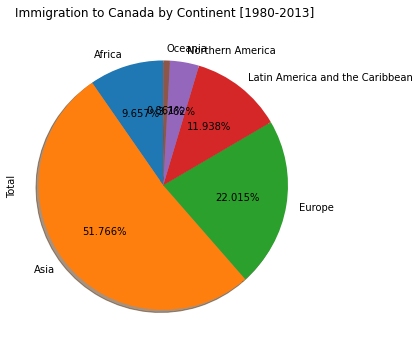

In [40]:
#autopct create %, start angle represent starting point
df_continent['Total'].plot(kind='pie',
                           figsize=(5,6),
                           autopct='%2.3f%%', #add in percentage
                           startangle=90,#Start angle is 90 for Africa
                           shadow=True
                          )

plt.title('Immigration to Canada by Continent [1980-2013]')
plt.axis('equal')
plt.show()            

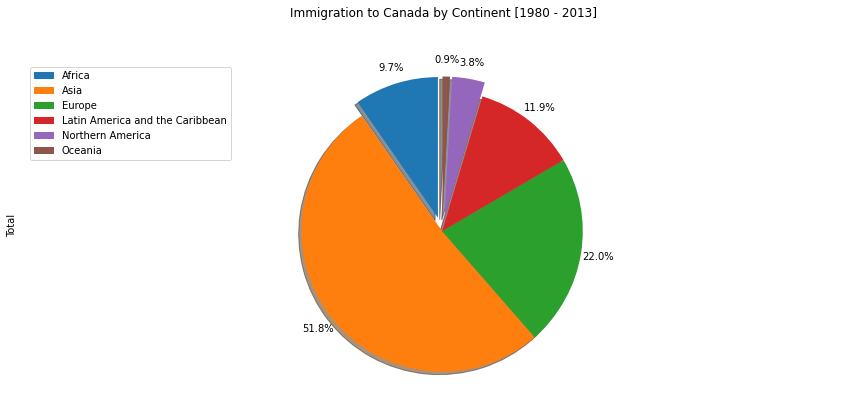

In [43]:
colors_list = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'lightgreen', 'pink']
explode_list = [0.1, 0, 0, 0, 0.1, 0.1] # ratio for each continent with which to offset each wedge.
df_continent['Total'].plot(kind='pie',
figsize=(15, 6),
autopct='%1.1f%%',
startangle=90,
shadow=True,
labels=None, # turn off labels on pie chart
pctdistance=1.12, # the ratio between the center of each pie slice and the start of thcolors=colors_list, # add custom colors
explode=explode_list # 'explode' lowest 3 continents
)
# scale the title up by 12% to match pctdistance
plt.title('Immigration to Canada by Continent [1980 - 2013]', y=1.12)
plt.axis('equal')
# add legend
plt.legend(labels=df_continent.index, loc='upper left')
plt.show()


In [9]:
df_can.shape

(195, 43)

In [11]:
df_can.head(5)

,Type,Coverage,OdName,AREA,AreaName,REG,RegName,DEV,DevName,1980,...,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
0,Immigrants,Foreigners,Afghanistan,935,Asia,5501,Southern Asia,902,Developing regions,16,...,2978,3436,3009,2652,2111,1746,1758,2203,2635,2004
1,Immigrants,Foreigners,Albania,908,Europe,925,Southern Europe,901,Developed regions,1,...,1450,1223,856,702,560,716,561,539,620,603
2,Immigrants,Foreigners,Algeria,903,Africa,912,Northern Africa,902,Developing regions,80,...,3616,3626,4807,3623,4005,5393,4752,4325,3774,4331
3,Immigrants,Foreigners,American Samoa,909,Oceania,957,Polynesia,902,Developing regions,0,...,0,0,1,0,0,0,0,0,0,0
4,Immigrants,Foreigners,Andorra,908,Europe,925,Southern Europe,901,Developed regions,0,...,0,0,1,1,0,0,0,0,1,1


Change few column names

In [15]:
df_can.rename(columns={'OdName':'Country','AreaName':'Continent','RegName':'Region'},inplace=True)
df_can.columns

Index([     'Type',  'Coverage',   'Country',      'AREA', 'Continent',
             'REG',    'Region',       'DEV',   'DevName',        1980,
              1981,        1982,        1983,        1984,        1985,
              1986,        1987,        1988,        1989,        1990,
              1991,        1992,        1993,        1994,        1995,
              1996,        1997,        1998,        1999,        2000,
              2001,        2002,        2003,        2004,        2005,
              2006,        2007,        2008,        2009,        2010,
              2011,        2012,        2013],
      dtype='object')

In [16]:
df_can.Country

0         Afghanistan
1             Albania
2             Algeria
3      American Samoa
4             Andorra
            ...      
190          Viet Nam
191    Western Sahara
192             Yemen
193            Zambia
194          Zimbabwe
Name: Country, Length: 195, dtype: object

In [21]:
df_can[['Country',1980, 1981, 1982, 1983, 1984, 1985]]

,Country,1980,1981,1982,1983,1984,1985
0,Afghanistan,16,39,39,47,71,340
1,Albania,1,0,0,0,0,0
2,Algeria,80,67,71,69,63,44
3,American Samoa,0,1,0,0,0,0
4,Andorra,0,0,0,0,0,0
...,...,...,...,...,...,...,...
190,Viet Nam,1191,1829,2162,3404,7583,5907
191,Western Sahara,0,0,0,0,0,0
192,Yemen,1,2,1,6,0,18
193,Zambia,11,17,11,7,16,9
